# **MONTECARLO** con Cartera (**AAPL, CAT, MSFT**)

Se valora una opción *call* asiática sobre una cesta de tres activos (AAPL, CAT, MSFT). 
Siguiendo la descripción técnica del reto, se implementa una simulación de Montecarlo para estimar la prima de la opción. 

El modelo se basa en el **Movimiento Browniano Geométrico** para simular las trayectorias de los precios, incorporando la correlación histórica entre los activos.

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gmean

### **Paso 1: Obtención de Datos y Parámetros Estadísticos**

Para simular el comportamiento futuro de los activos, primero necesitamos entender su comportamiento histórico. A partir de los precios de cierre, calculamos los **retornos logarítmicos**, que son la base para obtener dos parámetros cruciales:

1.  **Volatilidad (σ):** Mide la intensidad de las fluctuaciones del precio de un activo.
2.  **Correlación:** Indica cómo se mueven los precios de los activos entre sí.

In [14]:
prec =  pd.read_csv("Datos/Transformados/cartera.csv", index_col=0)
prec.index = pd.to_datetime(prec.index)
precios = prec[['AAPL','CAT','MSFT']]
ret_simple = precios.pct_change().dropna()
ret_log = np.log(precios / precios.shift(1)).dropna()
rend = ret_log
corr_matrix = rend.corr().values
print("Matriz de correlaciones:\n", corr_matrix)
sigma_daily = rend.std().values
sigmas = sigma_daily * np.sqrt(252)
print("Volatilidades anualizadas:", sigmas)
S0 = precios.iloc[-1].values
print("Precios iniciales:", S0)

Matriz de correlaciones:
 [[1.         0.40273855 0.72089394]
 [0.40273855 1.         0.4063413 ]
 [0.72089394 0.4063413  1.        ]]
Volatilidades anualizadas: [0.34008671 0.3430685  0.30625337]
Precios iniciales: [137.27000427 216.71000671 271.6000061 ]


### **2. Simulación de Trayectorias de Precios**

El núcleo del método de Montecarlo es la generación de múltiples escenarios futuros. La siguiente función, `generar_P`, simula `M` posibles trayectorias de precios para los 3 activos durante `N` pasos de tiempo.

El modelo utilizado es el **Movimiento Browniano Geométrico**.

Para incorporar la correlación, se utiliza la **descomposición de Cholesky** sobre la matriz de correlación histórica, lo que permite generar "ruidos" aleatorios que respetan la interdependencia entre los activos.

In [15]:
import numpy as np

def generar_P(M, n, T, corr, rf, vol, seed=42):
    """
    Genera la matriz P de forma vectorizada, sin bucles for.
    Las condiciones son idénticas a la función original.
    """
    # 1. Configuración Inicial
    # Calcula el incremento de tiempo 'dt' para cada paso de la simulación.
    dt = T / n
    # Se crea un generador de números aleatorios de numpy.
    rng = np.random.default_rng(seed=seed)

    # 2. Correlación de Activos con Cholesky
    # Descomposición de Cholesky para correlación:
    # A partir de la matriz de correlaciones 'corr', se obtiene la matriz L.
    # L es necesaria para generar variables aleatorias que mantengan la correlación entre los activos.
    L = np.linalg.cholesky(corr)
    # Se obtiene el numero de activos.
    n_assets = corr.shape[0]

    # 3. Generación de Pasos de Simulación
    # Creación de la Matriz de Ruido (Z)
    # Primeros 5 pasos iguales para todas las simulaciones:
    # Se genera una única secuencia de 5 valores aleatorios.
    Z_comun = rng.standard_normal(size=(5, n_assets))
    # Se multiplican por la transpuesta de L (L.T) para correlacionarlos.
    Z_comun = Z_comun @ L.T

    # Pasos 6 a 20 aleatorios:
    # Para cada simulación, se genera una nueva secuencia de valores aleatorios.
    # Se generan valores independientes para los pasos restantes (de 6 a n).
    Z_ind = rng.standard_normal(size=(M, n - 5, n_assets))

    # Se correlacionan de la misma manera que los pasos comunes.
    Z_ind = Z_ind @ L.T

    # Matriz vacía para Z:
    # Se inicializa una matriz tridimensional con ceros para almacenar los valores aleatorios (Z)
    # de cada activo, para cada paso de tiempo, en cada simulación.
    Z = np.zeros((M, n, n_assets))

    # Se asignan estos 5 pasos comunes a cada una de las 'M' simulaciones.
    Z[:, 0:5, :] = Z_comun
    # Se asignan estos ruidos únicos a la simulación 'p' desde el paso 5 en adelante.
    Z[:, 5:, :] = Z_ind

    # 4. Cálculo de la Evolución de Precios
    # Se aplica la fórmula del Movimiento Geométrico Browniano para calcular los
    # rendimientos de los activos en cada paso.
    P = np.e ** ((rf - (vol**2 / 2)) * dt + (vol * np.sqrt(dt) * Z))

    # Se añade una columna de unos al principio (t=0) de cada simulación.
    # Esto establece el precio inicial de todos los activos en 1.
    P = np.concatenate([np.ones((M, 1, n_assets)), P], axis=1)
    return P


In [16]:
T = 5       # años
r = 0.01    # tasa libre de riesgo
N = 20      # pasos
M = 1000000  # nº simulaciones
print("Volatilidades anualizadas:", sigmas)

Volatilidades anualizadas: [0.34008671 0.3430685  0.30625337]


### **3. Cálculo del Payoff y la Prima de la Opción**

Una vez simulados los `M` posibles futuros, calculamos el valor de la opción en cada uno de esos escenarios.

1.  **Cálculo del Payoff:** Para cada trayectoria, se calcula el valor final de la opción (*payoff*).
2.  **Cálculo de la Prima:** El precio justo de la opción hoy (la prima) es el promedio de todos los payoffs futuros, descontado a valor presente para reflejar el valor del dinero en el tiempo.

In [17]:
S0 = precios.iloc[-1].values

In [18]:
P= generar_P(M=M, n = N, T = T, rf = r, vol = sigmas, corr = corr_matrix)

In [19]:
# A partir de la matriz de rendimientos P, se calculan las trayectorias de precios acumuladas
# a lo largo del tiempo. El resultado 'S' contiene los precios simulados.
S = np.cumprod(P, axis = 1)

# Se calcula la media geometrica de los rendimientos de cada uno.
S_media = gmean(S[:, :], axis = 1) 

# Se calcula el payoff de la opcion para cada simulacion,
# cogiendo el maximo entre 0 y la resta entre el precio del ejercicio y el valor de la canasta
# Se coge el maximo ya que si es negativo el valor de la resta no se ejerce el derecho de compra.
payoff = np.maximum(np.sum(S_media, axis = 1) - 3, 0)

# Se calcula la media de los payoffs entre todas las simulaciones.
media_payoff = np.mean(payoff)

# Trae el valor de la media de los payoffs al valor presente
valor_actual2 = media_payoff * np.e**(-r * T)
print(f'El valor actual de la opcion es de: {valor_actual2}')

El valor actual de la opcion es de: 0.17668857668797514


### **4. Visualización de Resultados**

Finalmente, se visualiza una muestra de las trayectorias simuladas. Esto nos proporciona una comprobación visual de que el modelo está generando caminos de precios con la aleatoriedad y la tendencia esperadas, partiendo del precio normalizado de 1.

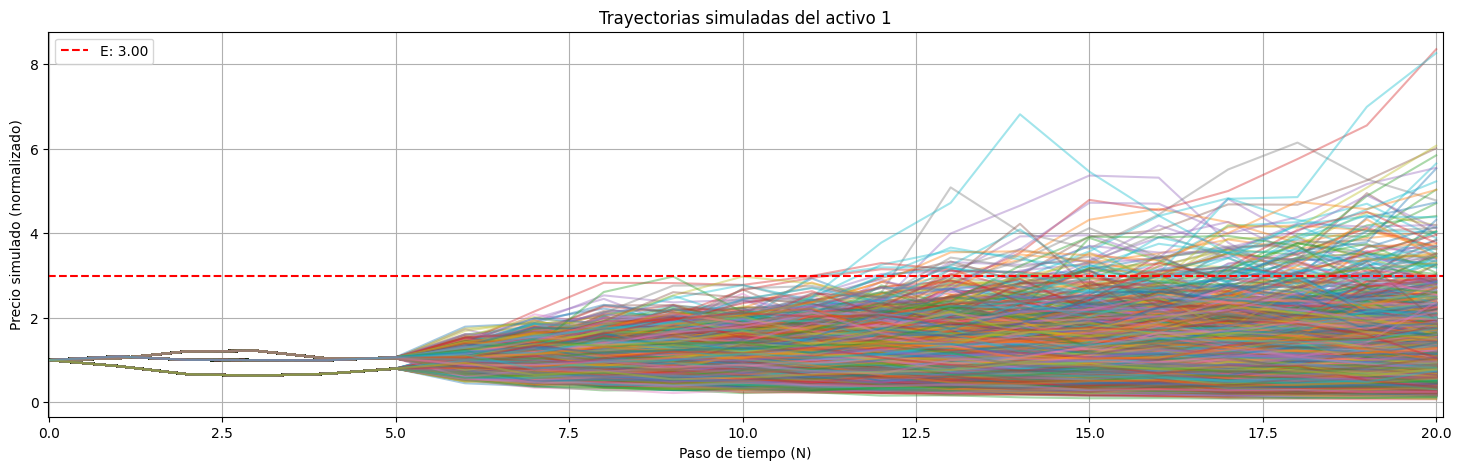

In [20]:
plt.figure(figsize=(18, 5))
for i in range(1000):  # plotea 20 trayectorias aleatorias del activo 1
    plt.plot(S[i, :], alpha=0.4)
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas del activo 1")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

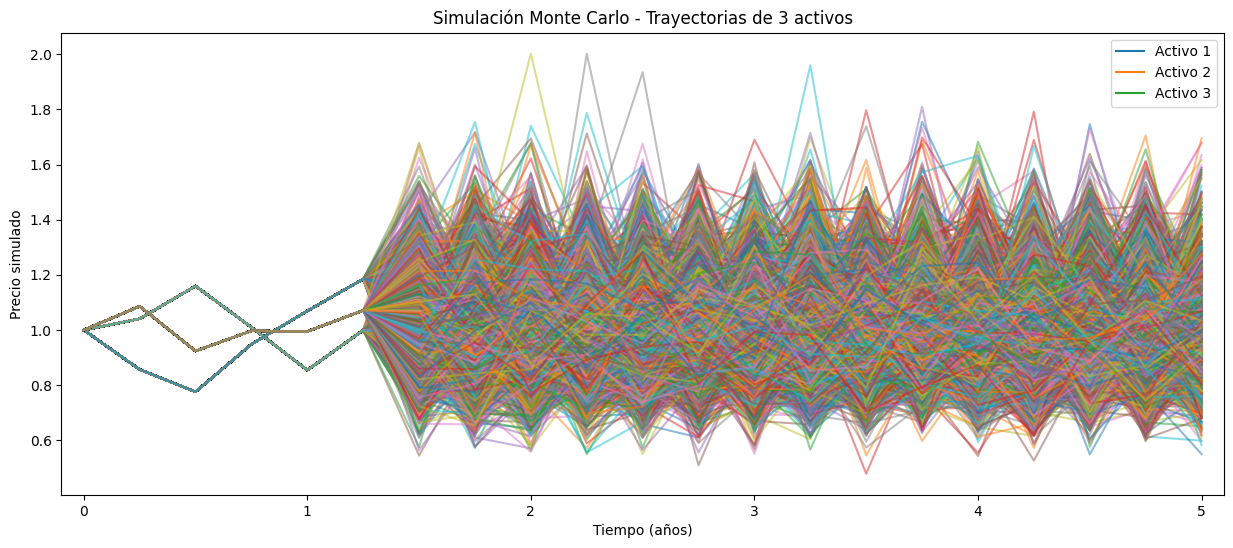

In [21]:
t = np.linspace(0, T, N+1)
fig, ax = plt.subplots(figsize=(15,6))
for i in range(3):  # tres activos
    for path in range(1000):
        ax.plot(t, P[path, :, i], alpha=0.5)
    ax.plot([], [], label=f'Activo {i+1}')  # solo para la leyenda
ax.set_title("Simulación Monte Carlo - Trayectorias de 3 activos")
ax.set_xlabel("Tiempo (años)")
ax.set_xlim(-0.1,5.1)
ax.set_ylabel("Precio simulado")
ax.legend()
plt.show()